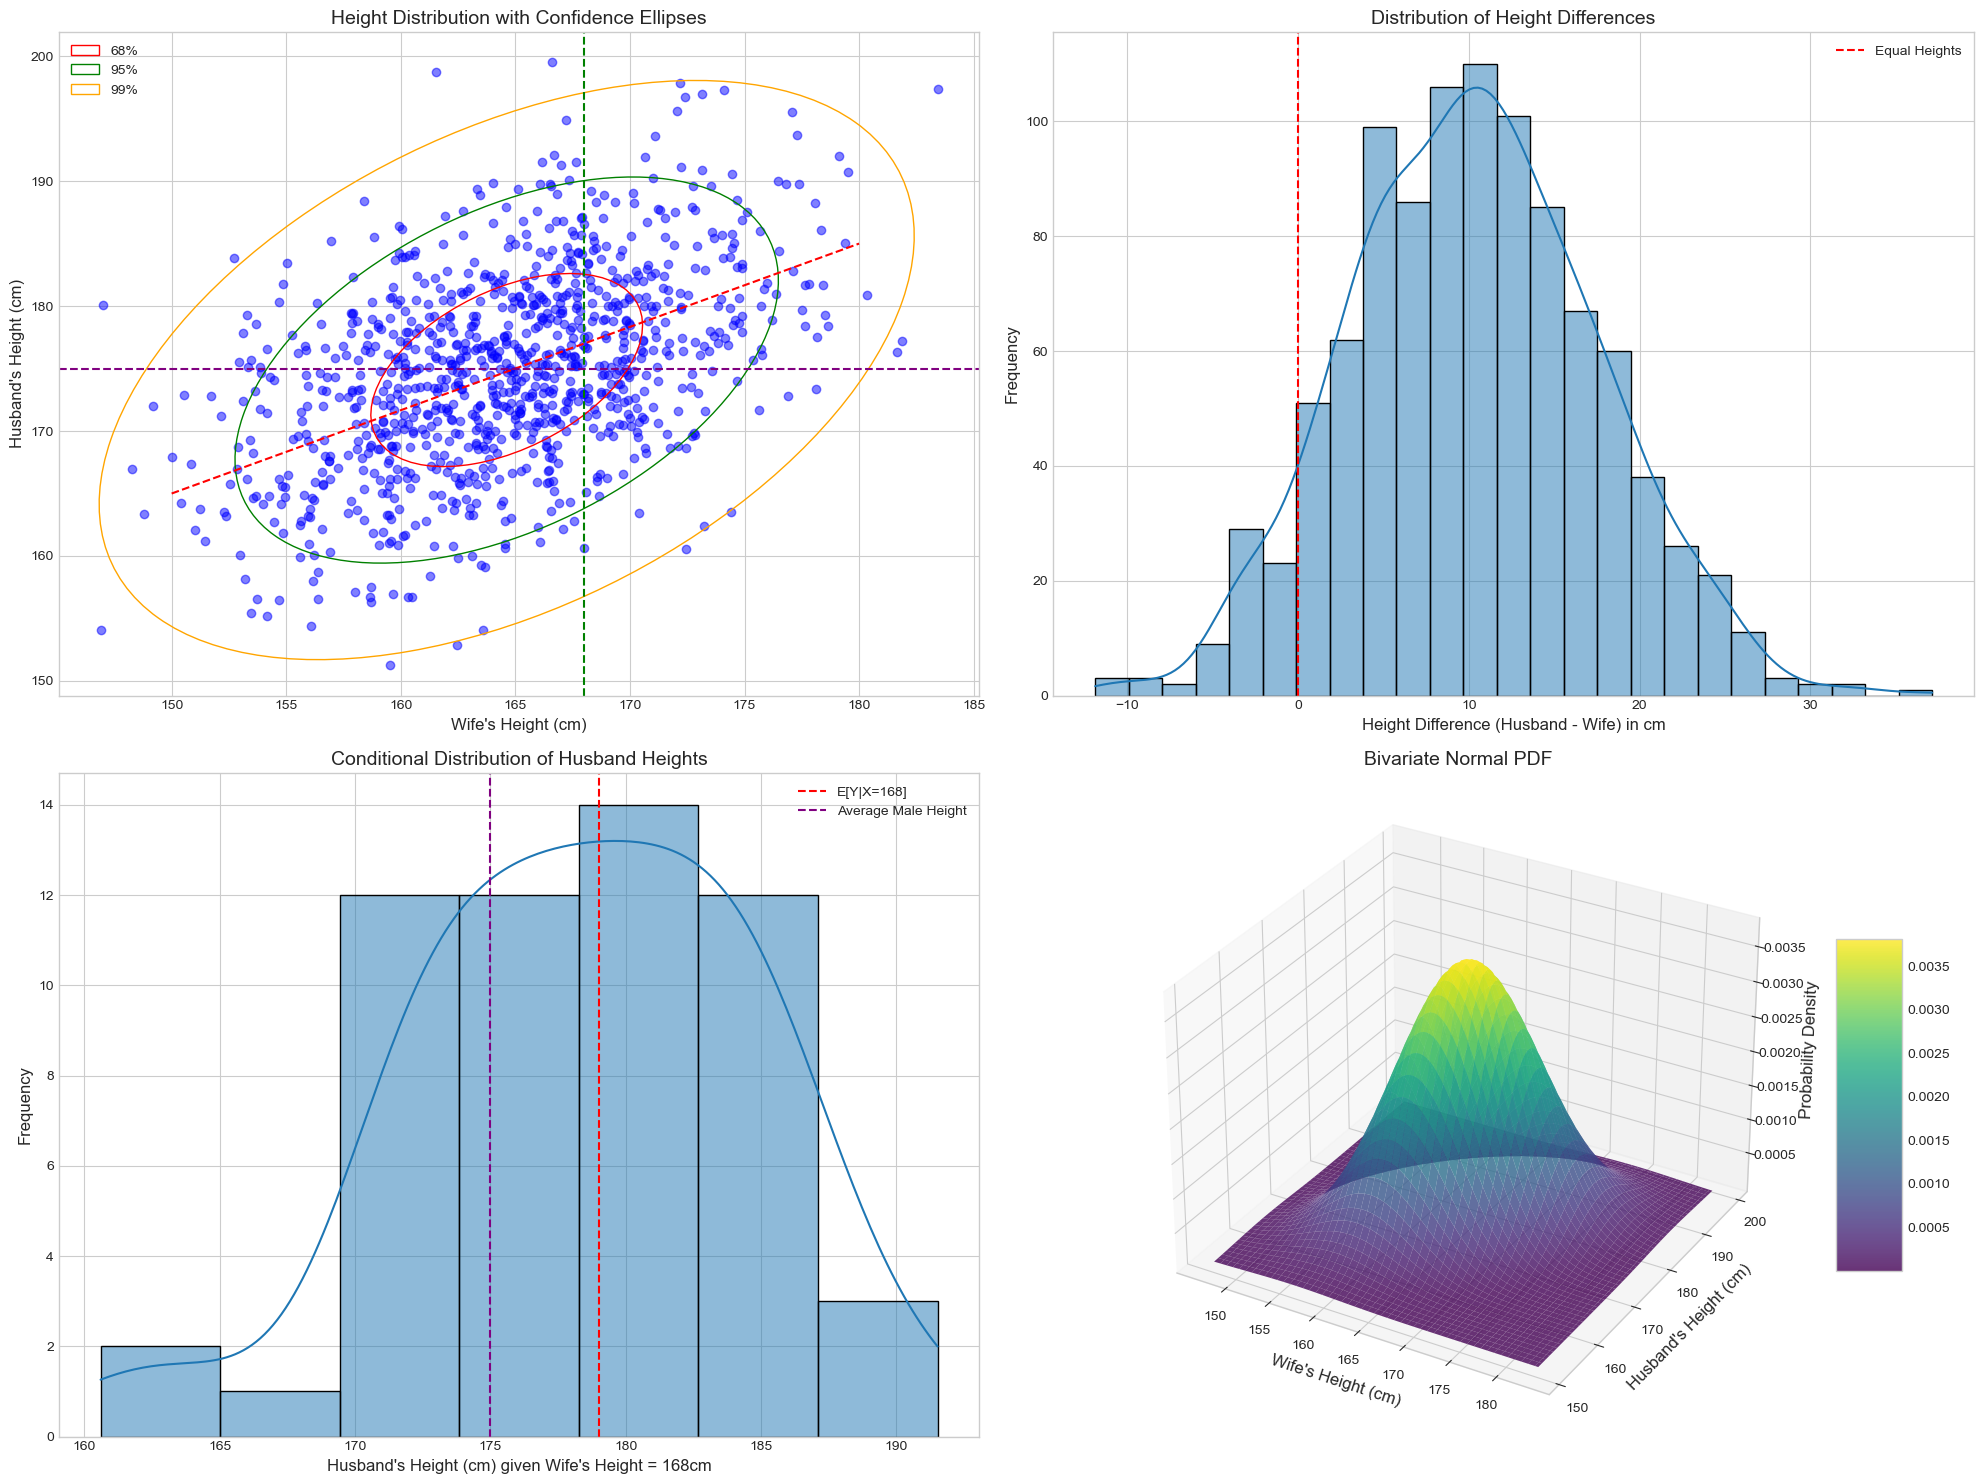


Key Statistics:
1. Expected husband's height given wife's height of 168cm: 177.00 cm
2. Probability that a random husband is taller than his wife: 0.9162
3. Probability that husband is above average height given wife's height of 168cm: 0.6071


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Set random seed for reproducibility
np.random.seed(42)

# Given parameters
mu_x = 165  # mean wife height
mu_y = 175  # mean husband height
sigma_x = 6  # standard deviation wife height
sigma_y = 8  # standard deviation husband height
rho = 0.5   # correlation coefficient

# Function to create confidence ellipse
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    # Using pearson correlation coefficient to handle numerical errors
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    
    transform = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))
    
    ellipse.set_transform(transform + ax.transData)
    return ax.add_patch(ellipse)

# Generate correlated random variables
def generate_correlated_heights(n_samples=1000):
    mean = [mu_x, mu_y]
    cov = [[sigma_x**2, rho*sigma_x*sigma_y],
           [rho*sigma_x*sigma_y, sigma_y**2]]
    
    return np.random.multivariate_normal(mean, cov, n_samples).T

# Create visualization
def create_height_visualizations(n_samples=1000):
    # Generate data
    x, y = generate_correlated_heights(n_samples)
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Scatter plot with confidence ellipses
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(x, y, c='blue', alpha=0.5)
    confidence_ellipse(x, y, ax1, n_std=1, label='68%', edgecolor='red')
    confidence_ellipse(x, y, ax1, n_std=2, label='95%', edgecolor='green')
    confidence_ellipse(x, y, ax1, n_std=3, label='99%', edgecolor='orange')
    
    ax1.set_xlabel("Wife's Height (cm)")
    ax1.set_ylabel("Husband's Height (cm)")
    ax1.set_title('Height Distribution with Confidence Ellipses')
    ax1.legend()
    ax1.grid(True)
    
    # Add the conditional expectation line for X=168
    x_range = np.linspace(150, 180, 100)
    y_conditional = mu_y + rho * (sigma_y/sigma_x) * (x_range - mu_x)
    ax1.plot(x_range, y_conditional, 'r--', label='Conditional Expectation')
    ax1.axvline(x=168, color='g', linestyle='--', label='X=168')
    ax1.axhline(y=175, color='purple', linestyle='--', label='Average Male Height')
    
    # 2. Height difference distribution
    ax2 = fig.add_subplot(gs[0, 1])
    height_diff = y - x
    sns.histplot(height_diff, kde=True, ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--', label='Equal Heights')
    ax2.set_xlabel('Height Difference (Husband - Wife) in cm')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Height Differences')
    ax2.legend()
    
    # 3. Conditional distribution for X=168
    ax3 = fig.add_subplot(gs[1, 0])
    mask = (x >= 167.5) & (x <= 168.5)
    y_conditional = y[mask]
    sns.histplot(y_conditional, kde=True, ax=ax3)
    ax3.axvline(x=179, color='r', linestyle='--', label='E[Y|X=168]')
    ax3.axvline(x=175, color='purple', linestyle='--', label='Average Male Height')
    ax3.set_xlabel("Husband's Height (cm) given Wife's Height = 168cm")
    ax3.set_ylabel('Frequency')
    ax3.set_title('Conditional Distribution of Husband Heights')
    ax3.legend()
    
    # 4. 3D surface plot of bivariate normal PDF
    ax4 = fig.add_subplot(gs[1, 1], projection='3d')
    x_range = np.linspace(mu_x - 3*sigma_x, mu_x + 3*sigma_x, 100)
    y_range = np.linspace(mu_y - 3*sigma_y, mu_y + 3*sigma_y, 100)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Calculate PDF values
    pos = np.dstack((X, Y))
    rv = stats.multivariate_normal([mu_x, mu_y], [[sigma_x**2, rho*sigma_x*sigma_y],
                                                 [rho*sigma_x*sigma_y, sigma_y**2]])
    Z = rv.pdf(pos)
    
    # Plot the surface
    surf = ax4.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax4.set_xlabel("Wife's Height (cm)")
    ax4.set_ylabel("Husband's Height (cm)")
    ax4.set_zlabel('Probability Density')
    ax4.set_title('Bivariate Normal PDF')
    fig.colorbar(surf, ax=ax4, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    return fig

# Create and display the visualizations
fig = create_height_visualizations()
plt.show()

# Calculate and print some key statistics
def print_statistics():
    print("\nKey Statistics:")
    print(f"1. Expected husband's height given wife's height of 168cm: {175 + 0.5 * (8/6) * (168-165):.2f} cm")
    
    # Calculate probability that husband is taller than wife
    n_samples = 100000
    x, y = generate_correlated_heights(n_samples)
    prob_taller = np.mean(y > x)
    print(f"2. Probability that a random husband is taller than his wife: {prob_taller:.4f}")
    
    # Calculate probability that husband is above average height given wife's height
    mask = (x >= 167.5) & (x <= 168.5)
    y_conditional = y[mask]
    prob_above_avg = np.mean(y_conditional > 175)
    print(f"3. Probability that husband is above average height given wife's height of 168cm: {prob_above_avg:.4f}")

print_statistics()